In [1]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 90.6 MB/s eta 0:00:00


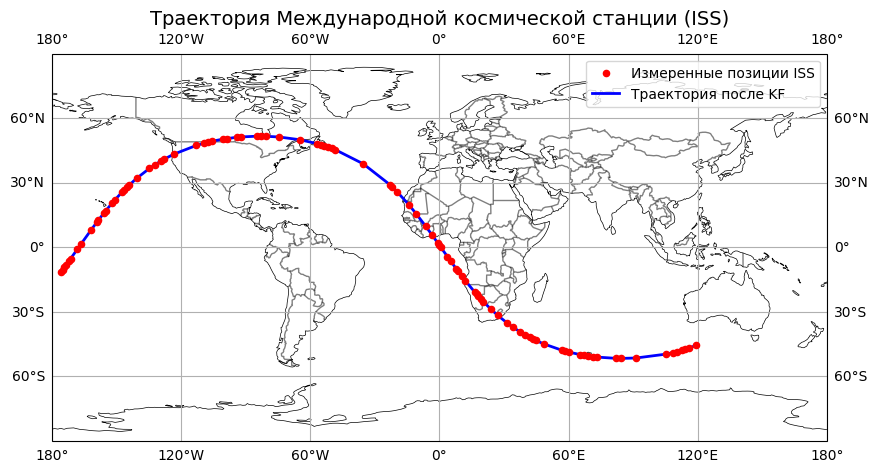

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Загрузка данных
df = pd.read_csv("iss_data_log.csv")

# Фильтрация данных
df1 = df[df['timestamp'] > 1749572700]
df1 = df1[df1['timestamp'] % 4 == 0]

# Координаты для трека
lats = df1['latitude'].values
lons = df1['longitude'].values

# Функция фильтра Калмана
class KalmanFilter:
    def __init__(self, dt, std_acc, x_std_meas, y_std_meas):
        """
        :param dt: Временной шаг между измерениями
        :param std_acc: Стандартное отклонение акселерометра (шум процесса)
        :param x_std_meas: Стандартное отклонение измерений по оси X (широта)
        :param y_std_meas: Стандартное отклонение измерений по оси Y (долгота)
        """
        # Матрица перехода
        self.F = np.array([[1, 0, dt, 0],
                           [0, 1, 0, dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])

        # Матрица наблюдения
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])

        # Ковариационная матрица шума процесса
        self.Q = np.eye(4) * std_acc**2

        # Ковариационная матрица шума измерений
        self.R = np.eye(2) * np.diag([x_std_meas**2, y_std_meas**2])

        # Ковариационная матрица ошибки оценки
        self.P = np.eye(4)

        # Состояние системы (начальное значение)
        self.x = np.zeros((4, 1))

    def predict(self):
        """ Предсказать следующее состояние """
        self.x = np.dot(self.F, self.x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q

    def update(self, z):
        """ Обновить состояние с новыми измерениями """
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, (z - np.dot(self.H, self.x)))
        I = np.eye(self.H.shape[1])
        self.P = np.dot(I - np.dot(K, self.H), self.P)

# Параметры фильтра Калмана
dt = 10  # Временной шаг между измерениями (в секундах)
std_acc = 0.5  # Шум процесса (ускорение)
x_std_meas = 0.1  # Шум измерений по широте
y_std_meas = 0.1  # Шум измерений по долготе

# Инициализация фильтра Калмана
kf = KalmanFilter(dt, std_acc, x_std_meas, y_std_meas)

# Списки для хранения фильтрованных данных
filtered_lats = []
filtered_lons = []

# Применение фильтра Калмана к данным
for lat, lon in zip(lats, lons):
    # Измерения
    z = np.array([[lat], [lon]])

    # Предсказание
    kf.predict()

    # Обновление
    kf.update(z)

    # Сохранение фильтрованных данных
    filtered_lats.append(kf.x[0][0])
    filtered_lons.append(kf.x[1][0])

# Создаём карту с проекцией Mercator
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Настройки карты
ax.set_global()
ax.coastlines(resolution='110m', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Рисуем исходные данные
ax.scatter(lons, lats, color='red', s=20, transform=ccrs.PlateCarree(), zorder=5, label='Измеренные позиции ISS')

# Рисуем фильтрованные данные
ax.plot(filtered_lons, filtered_lats, color='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Траектория после KF')

# Добавляем заголовок и легенду
plt.title('Траектория Международной космической станции (ISS)', fontsize=14)
plt.legend()

# Отображаем карту
plt.show()

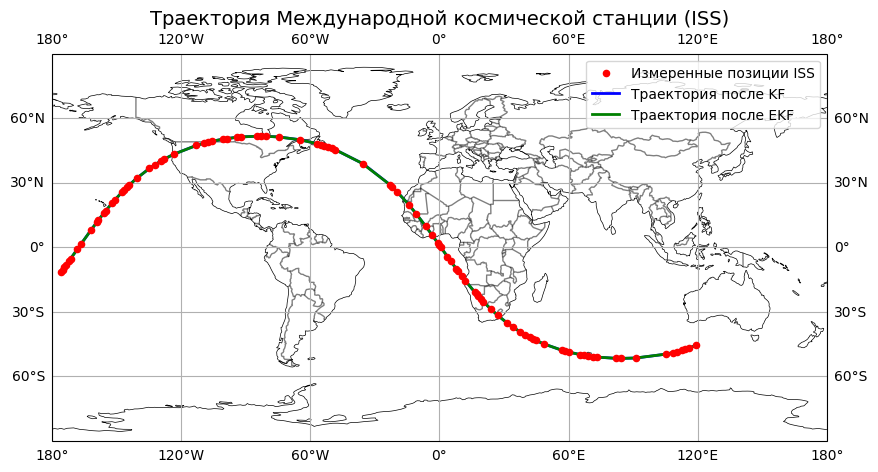

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Загрузка данных
df = pd.read_csv("iss_data_log.csv")

# Фильтрация данных
df1 = df[df['timestamp'] > 1749572700]
df1 = df1[df1['timestamp'] % 4 == 0]

# Координаты для трека
lats = df1['latitude'].values
lons = df1['longitude'].values

# Функция расширенного фильтра Калмана
class ExtendedKalmanFilter:
    def __init__(self, dt, std_acc, x_std_meas, y_std_meas):
        """
        :param dt: Временной шаг между измерениями
        :param std_acc: Стандартное отклонение акселерометра (шум процесса)
        :param x_std_meas: Стандартное отклонение измерений по оси X (широта)
        :param y_std_meas: Стандартное отклонение измерений по оси Y (долгота)
        """
        # Матрица перехода (начальное приближение)
        self.F = np.eye(4)

        # Матрица наблюдения
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])

        # Ковариационная матрица шума процесса
        self.Q = np.eye(4) * std_acc**2

        # Ковариационная матрица шума измерений
        self.R = np.eye(2) * np.diag([x_std_meas**2, y_std_meas**2])

        # Ковариационная матрица ошибки оценки
        self.P = np.eye(4)

        # Состояние системы (начальное значение)
        self.x = np.zeros((4, 1))

    def predict(self):
        """ Предсказать следующее состояние """
        self.x = np.dot(self.F, self.x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q

    def update(self, z):
        """ Обновить состояние с новыми измерениями """
        # Линеаризация модели
        y = z - np.dot(self.H, self.x)
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.H.shape[1])
        self.P = np.dot(I - np.dot(K, self.H), self.P)

# Параметры EKF
dt = 10  # Временной шаг между измерениями (в секундах)
std_acc = 0.5  # Шум процесса (ускорение)
x_std_meas = 0.1  # Шум измерений по широте
y_std_meas = 0.1  # Шум измерений по долготе

# Инициализация EKF
ekf = ExtendedKalmanFilter(dt, std_acc, x_std_meas, y_std_meas)

# Списки для хранения фильтрованных данных
filtered_lats_ekf = []
filtered_lons_ekf = []

# Применение EKF к данным
for lat, lon in zip(lats, lons):
    # Измерения
    z = np.array([[lat], [lon]])

    # Предсказание
    ekf.predict()

    # Обновление
    ekf.update(z)

    # Сохранение фильтрованных данных
    filtered_lats_ekf.append(ekf.x[0][0])
    filtered_lons_ekf.append(ekf.x[1][0])

# Создаём карту с проекцией Mercator
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Настройки карты
ax.set_global()
ax.coastlines(resolution='110m', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Рисуем исходные данные
ax.scatter(lons, lats, color='red', s=20, transform=ccrs.PlateCarree(), zorder=5, label='Измеренные позиции ISS')

# Рисуем данные после KF
ax.plot(filtered_lons, filtered_lats, color='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Траектория после KF')

# Рисуем данные после EKF
ax.plot(filtered_lons_ekf, filtered_lats_ekf, color='green', linewidth=2, transform=ccrs.PlateCarree(), label='Траектория после EKF')

# Добавляем заголовок и легенду
plt.title('Траектория Международной космической станции (ISS)', fontsize=14)
plt.legend()

# Отображаем карту
plt.show()